In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import SGD, Adam
from keras.utils import to_categorical
from scipy.special import erfc
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from utils import Encoder, Decoder, awgn
from file_gen import *

In [2]:
CONFIG_TRAIN = {
    "M": 16,  # Number of constellation points
    "flag_train_model": True,  # Flag to control training
    "training_snr": 12,  # Training SNR (dB)
    "best_model_path": "./model/ae_simo_rayleigh_16qam_best_model.pth",  # Path to save the best model
    "latest_checkpoint_path": "./model/ae_simo_rayleigh_16qam_latest_checkpoint.pth",  # Path to save the latest checkpoint
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
encoder = Encoder([CONFIG_TRAIN["M"], 64, 64, 64, 2]).to(device)
decoder = Decoder([8, 512, 512, 512, CONFIG_TRAIN["M"]]).to(device)

In [4]:
def plot_symbols(epoch, encoder, device):
    """
    Plot the transmitted symbols in the I-Q plane and save the plot to a file.
    - epoch: Current epoch
    - encoder: Encoder model
    - device: Device to run the model
    """

    num_mess = 6400  # Number of messages to test
    messages = torch.randint(0, CONFIG_TRAIN["M"], size=(num_mess,)).to(device)
    one_hot = F.one_hot(messages, num_classes=CONFIG_TRAIN["M"]).float()
    tx = encoder(one_hot)
    tx = tx.to("cpu").detach().numpy()

    # Plot transmitted symbols
    plt.figure()
    plt.scatter(tx[:, 0], tx[:, 1])
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.title("Transmitted Constellation")
    plt.grid(True)
    plt.xlim(-1.3, 1.3)
    plt.ylim(-1.3, 1.3)
    plt.tight_layout()
    plt.savefig(
        f"./epoch_plots/ae_simo_rayleigh_16qam/epoch_{epoch}.png"
    )  # Ensure the ./epoch_plots directory exists
    plt.close()

Resuming training from epoch 4519


training process:   2%|▏         | 112/5481 [00:10<08:36, 10.40it/s]


Training interrupted


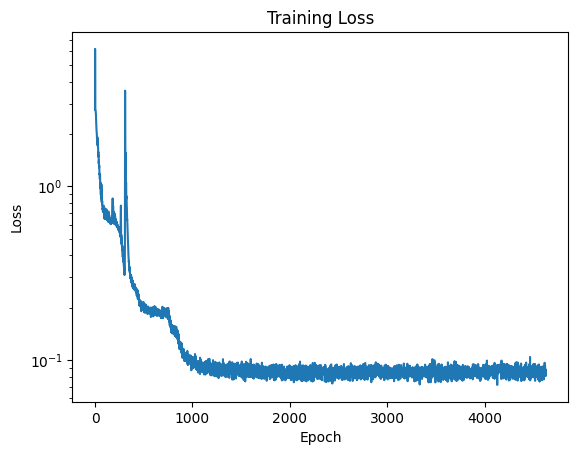

In [5]:
def save_model(encoder, decoder, loss, optimizer, model_type="latest"):
    """
    Save the model to a file.
    - encoder: the encoder model
    - decoder: the decoder model
    - loss: the loss history
    - optimizer: the optimizer
    - model_type: "latest"(default) or "best"
    """

    if model_type == "best":  # Decide the filename based on model_type
        filename = CONFIG_TRAIN["best_model_path"]
    else:
        filename = CONFIG_TRAIN["latest_checkpoint_path"]
    torch.save(
        {
            "Encoder": encoder.state_dict(),
            "Decoder": decoder.state_dict(),
            "loss": loss,
            "optimizer": optimizer.state_dict(),
        },
        filename,
    )


def early_stopping(loss_hist, patience=5):
    """
    Check if the training should be stopped early.
    - loss_hist: list of loss values
    - patience: number of epochs to wait before stopping
    """

    if len(loss_hist) > patience:
        if all(
            x > loss_hist[-1] for x in loss_hist[-(patience + 1) :]
        ):  # if the last patience losses are decreasing
            return True
    return False


def simo_rayleigh_channel(tx, snr, device):
    """
    Simulate the signal passing through a channel.

    Parameters:
    - tx: Transmitted signal tensor.
    - snr: Signal to Noise Ratio in dB.
    - device: Device to perform computations on.

    Returns:
    - rx: Received signal tensor after passing through the channel.
    """

    # Generate channel coefficients
    ch_real1 = torch.randn(tx.shape[0]).to(device)
    ch_imag1 = torch.randn(tx.shape[0]).to(device)
    ch_real2 = torch.randn(tx.shape[0]).to(device)
    ch_imag2 = torch.randn(tx.shape[0]).to(device)
    csi = torch.stack((ch_real1, ch_imag1, ch_real2, ch_imag2), dim=1)

    # Perform complex multiplication to simulate channel
    rx_real1 = ch_real1 * tx[:, 0] - ch_imag1 * tx[:, 1]
    rx_imag1 = ch_imag1 * tx[:, 0] + ch_real1 * tx[:, 1]
    rx_real2 = ch_real2 * tx[:, 0] - ch_imag2 * tx[:, 1]
    rx_imag2 = ch_imag2 * tx[:, 0] + ch_real2 * tx[:, 1]

    # Stack real and imaginary parts to form received signal
    rx = torch.stack((rx_real1, rx_imag1, rx_real2, rx_imag2), dim=1)

    # Add AWGN noise
    rx = awgn(rx, snr)

    # Concatenate channel state information
    rx_csi = torch.cat((rx, csi), dim=1)

    return rx_csi


def train_model(encoder, decoder, optimizer, tot_epochs, loss_hist, device):
    """
    Train the model.
    - encoder: the encoder model
    - decoder: the decoder model
    - optimizer: the optimizer
    - tot_epochs: the number of epochs to train
    - loss_hist: the history of loss values
    """

    criterion = nn.NLLLoss()  # negative log likelihood loss
    best_loss = float("inf")  # Initialize the best loss to infinity
    # Use a try-except block to handle keyboard interrupts
    try:
        # Use tqdm to show a progress bar
        for epoch in tqdm(range(len(loss_hist), tot_epochs), desc="training process"):
            messages = torch.randint(
                0, CONFIG_TRAIN["M"], size=(num_messages,), device=device
            )  # generate random messages
            one_hot = F.one_hot(
                messages, CONFIG_TRAIN["M"]
            ).float()  # convert to one hot encoding
            tx = encoder(one_hot)  # type of tx is torch.float32

            rx_csi = simo_rayleigh_channel(tx, CONFIG_TRAIN["training_snr"], device)

            y_pred_ae = decoder(rx_csi)

            loss = criterion(y_pred_ae, messages)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
                save_model(encoder, decoder, loss_hist, optimizer, model_type="best")

            if (epoch % 50) == 0:
                plot_symbols(epoch, encoder, device)

            if (epoch % 200) == 0:
                save_model(encoder, decoder, loss_hist, optimizer, model_type="latest")

            if early_stopping(loss_hist):
                save_model(encoder, decoder, loss_hist, optimizer, model_type="latest")
                print("Early stopping")
                break

        print("Training complete")

    except KeyboardInterrupt:
        save_model(encoder, decoder, loss_hist, optimizer, model_type="latest")
        print("Training interrupted")

    # Plot the loss
    plt.semilogy(loss_hist)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()


if CONFIG_TRAIN["flag_train_model"]:
    # check if there is a checkpoint to resume training
    if os.path.exists(CONFIG_TRAIN["latest_checkpoint_path"]):
        checkpoint = torch.load(
            CONFIG_TRAIN["latest_checkpoint_path"], map_location=device
        )
        # load the model, optimizer a loss history
        encoder.load_state_dict(checkpoint["Encoder"])
        decoder.load_state_dict(checkpoint["Decoder"])
        parameters = list(encoder.parameters()) + list(decoder.parameters())
        optimizer = Adam(parameters, lr=0.01)
        optimizer.load_state_dict(checkpoint["optimizer"])
        loss_hist = checkpoint["loss"]
        print(f"Resuming training from epoch {len(loss_hist)}")
    else:  # start training from scratch
        parameters = list(encoder.parameters()) + list(decoder.parameters())
        optimizer = Adam(parameters, lr=0.01)
        loss_hist = []
        print("Training from scratch")

    tot_epochs = int(1e4)  # Total number of epochs to train
    num_messages = int(1e4)  # Number of messages to use for training (batch size)
    if tot_epochs > len(loss_hist):
        train_model(encoder, decoder, optimizer, tot_epochs, loss_hist, device)
    else:
        print("epochs already completed")
else:
    # check if there is a checkpoint to load the model
    if os.path.exists(CONFIG_TRAIN["best_model_path"]):
        checkpoint = torch.load(CONFIG_TRAIN["best_model_path"], map_location=device)
        encoder.load_state_dict(checkpoint["Encoder"])
        decoder.load_state_dict(checkpoint["Decoder"])
        print("Model loaded. Training epoch: ", len(checkpoint["loss"]))
    else:
        print(
            "Model not found, please set flag_train_model to True and train the model"
        )
        exit(1)

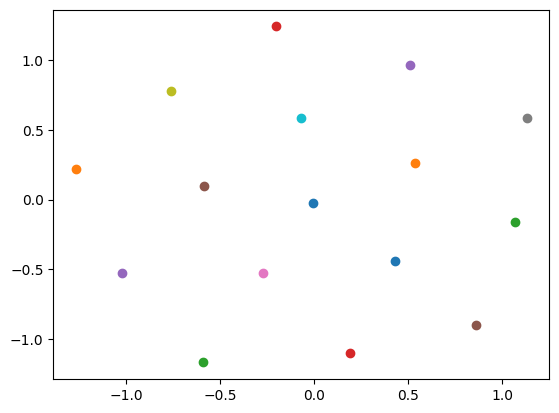

In [7]:
# Generate transmitted symbols using the encoder
tensor = torch.arange(16).to(device)
one_hot = F.one_hot(tensor, CONFIG_TRAIN["M"]).float()
tx = encoder(one_hot)
tx = tx.to("cpu").detach().numpy()
for i in range(CONFIG_TRAIN["M"]):
    plt.scatter(tx[i, 0], tx[i, 1])

constellation = np.array([tx[:, 0] + 1j * tx[:, 1]]).T

In [8]:
SNR_dB = np.arange(2, 22, 2)

# Monte Carlo simulation of the SER for the trained model and MRC receiver
SER_ae = np.array([])
SER_mrc = np.array([])
iteration = tqdm(range(len(SNR_dB)), desc="simulation process")
for iterator in iteration:
    snr = SNR_dB[iterator]
    num_mess = 6400  # number of messages to test
    minErr = 1  # minimum number of errors
    minSym = 1e6  # minimum number of symbols
    totSym = 0  # total number of symbols
    totErr_ae = 0  # total number of errors
    totErr_mrc = 0  # total number of errors
    while totErr_ae < minErr or totSym < minSym or totErr_mrc < minErr:
        messages = torch.randint(0, CONFIG_TRAIN["M"], size=(num_mess,)).to(device)
        one_hot = F.one_hot(messages).float()
        tx = encoder(one_hot)
        ch_real1 = torch.randn(tx.shape[0]).to(device)
        ch_imag1 = torch.randn(tx.shape[0]).to(device)
        ch_real2 = torch.randn(tx.shape[0]).to(device)
        ch_imag2 = torch.randn(tx.shape[0]).to(device)
        csi = torch.stack((ch_real1, ch_imag1, ch_real2, ch_imag2), dim=1)
        rx_real1 = torch.mul(ch_real1, tx[:, 0]) - torch.mul(ch_imag1, tx[:, 1])
        rx_imag1 = torch.mul(ch_imag1, tx[:, 0]) + torch.mul(ch_real1, tx[:, 1])
        rx_real2 = torch.mul(ch_real2, tx[:, 0]) - torch.mul(ch_imag2, tx[:, 1])
        rx_imag2 = torch.mul(ch_imag2, tx[:, 0]) + torch.mul(ch_real2, tx[:, 1])
        rx = torch.stack((rx_real1, rx_imag1, rx_real2, rx_imag2), dim=1)
        rx = awgn(rx, snr)
        rx_csi = torch.cat((rx, csi), dim=1)

        # Decoder receiver
        y_pred_ae = decoder(rx_csi)
        pred_ae = torch.argmax(y_pred_ae, 1)
        err_ae = (pred_ae != messages).sum()
        totErr_ae += err_ae.cpu()

        # MRC receiver
        ch1 = np.array([ch_real1 + 1j * ch_imag1]).T
        ch2 = np.array([ch_real2 + 1j * ch_imag2]).T
        ch = np.hstack((ch1, ch2))
        w = np.conj(ch) / np.sum(np.abs(ch) ** 2, axis=1, keepdims=True)
        # Extract real and imaginary parts from rx
        rx_real = rx[:, [0, 2]]  # Select columns containing real parts
        rx_imag = rx[:, [1, 3]]  # Select columns containing imaginary parts
        # Convert to numpy arrays and combine real and imaginary parts to form complex numbers
        rx_complex = (
            rx_real.detach().cpu().numpy() + 1j * rx_imag.detach().cpu().numpy()
        )
        y_pred_mrc = np.sum(rx_complex * w, axis=1, keepdims=True)
        # Calculate Euclidean distances between each point in rx_complex and each point in the constellation
        distances = np.sqrt(
            np.sum(np.abs(y_pred_mrc[:, np.newaxis] - constellation) ** 2, axis=2)
        )
        # Find the index of the closest point in the constellation for each point in rx_complex
        pred_mrc = np.argmin(distances, axis=1)
        # calculate the number of errors
        err = np.sum(pred_mrc != messages.cpu().numpy())
        totErr_mrc += err

        totSym += num_mess
    SER_ae = np.append(SER_ae, totErr_ae / totSym)
    SER_mrc = np.append(SER_mrc, totErr_mrc / totSym)

simulation process: 100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


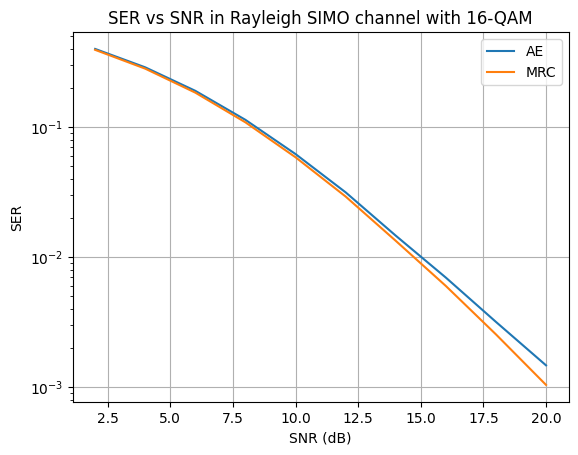

In [9]:
plt.figure()
plt.plot(SNR_dB, SER_ae, label="AE")
plt.plot(SNR_dB, SER_mrc, label="MRC")
plt.yscale("log")
plt.xlabel("SNR (dB)")
plt.ylabel("SER")
plt.grid()
plt.legend()
plt.title("SER vs SNR in Rayleigh SIMO channel with 16-QAM")
plt.show()

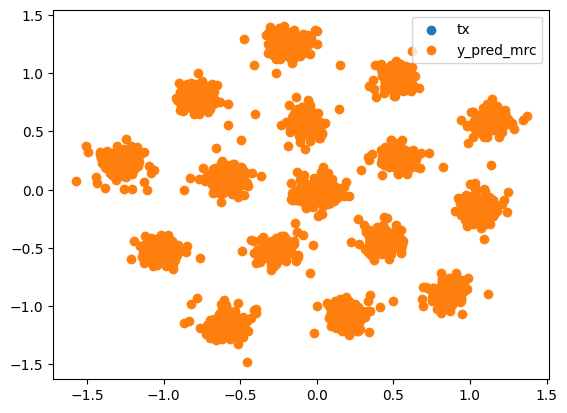

In [16]:
# plot tx, rx, and y_pred_mrc
tx = tx.to("cpu").detach().numpy()
plt.figure()
plt.scatter(tx[:, 0], tx[:, 1], label="tx")
# plt.scatter(rx_complex[:, 0], rx_complex[:, 1], label='rx')
plt.scatter(y_pred_mrc.real, y_pred_mrc.imag, label="y_pred_mrc")
plt.legend()
plt.show()

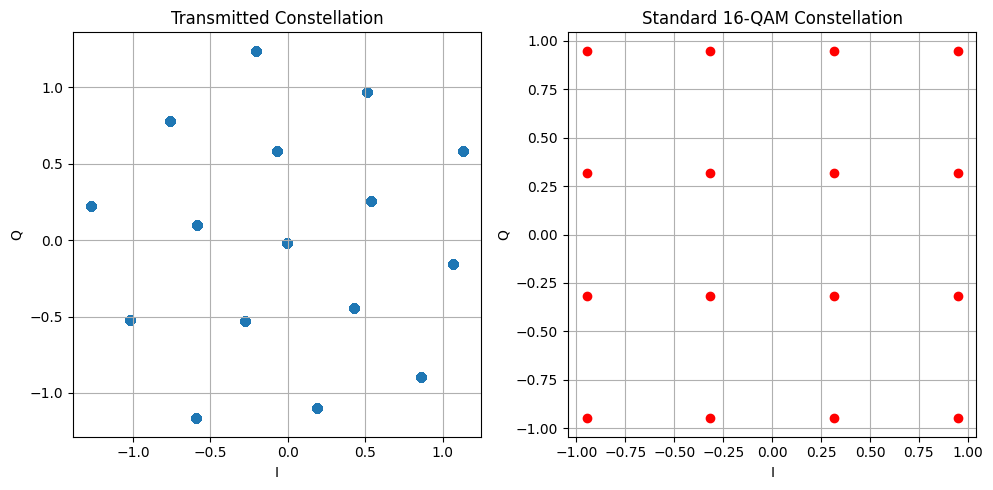

In [17]:
# Generate transmitted symbols using the encoder
num_mess = 6400  # number of messages to test
messages = torch.randint(0, CONFIG_TRAIN["M"], size=(num_mess,)).to(device)
one_hot = F.one_hot(messages).float()
tx = encoder(one_hot)
tx = tx.to("cpu").detach().numpy()

# Define the coordinates for 16-QAM constellation points
points_I = np.array([1, 1, 1, 1, -1, -1, -1, -1, 3, 3, 3, 3, -3, -3, -3, -3]) / np.sqrt(
    10
)
points_Q = np.array([3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3]) / np.sqrt(
    10
)

# Plot both constellations
plt.figure(figsize=(10, 5))

# Plot transmitted symbols
plt.subplot(1, 2, 1)
plt.scatter(tx[:, 0], tx[:, 1])
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Transmitted Constellation")
plt.grid(True)

# Plot standard 16-QAM constellation
plt.subplot(1, 2, 2)
plt.scatter(points_I, points_Q, c="r")
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Standard 16-QAM Constellation")
plt.grid(True)

plt.tight_layout()
plt.show()